# Finetuning detection

We are going to load the test dataset from hugging face, it will download the train, validation and test

In [1]:
from datasets import load_dataset

hf_dataset = load_dataset("dimun/ExpirationDate", trust_remote_code=True)

Check the train, validation and test datasets with their size and attributes

In [2]:
# Print all the dataset
print(hf_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'transcriptions', 'bboxes_block', 'categories', 'image_path', 'width', 'height'],
        num_rows: 11858
    })
    validation: Dataset({
        features: ['id', 'transcriptions', 'bboxes_block', 'categories', 'image_path', 'width', 'height'],
        num_rows: 665
    })
    test: Dataset({
        features: ['id', 'transcriptions', 'bboxes_block', 'categories', 'image_path', 'width', 'height'],
        num_rows: 1102
    })
})


Check some images from the dataset and their bounding boxes, it will generate a random image from the dataset

image id:  img_01980.jpg
bboxes_block:  [[34, 48, 249, 70]]
width, height:  412 309


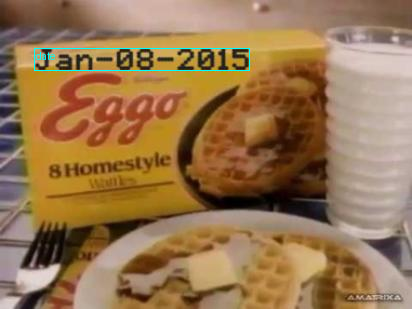

In [3]:
import torch
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from PIL import Image
import random

# Accessing categories from the dataset
categories = hf_dataset["train"].features["categories"].feature

# Take one random example from the train dataset
example = hf_dataset["train"][random.randint(0, hf_dataset["train"].num_rows)]

# Open the image and convert it to RGB mode
image = Image.open(example["image_path"]).convert("RGB")

# Extracting labels and bounding boxes from the example
labels = [categories.int2str(x) for x in example['categories']]
boxes_xyxy = torch.tensor(example['bboxes_block'])

# Printing image id, bounding box coordinates, width, and height
print("image id: ", example["id"])
print("bboxes_block: ", example["bboxes_block"])
print("width, height: ", example["width"], example["height"])

# Drawing bounding boxes on the image
to_pil_image(
    draw_bounding_boxes(
        pil_to_tensor(image),
        boxes_xyxy,
        colors="cyan",
        labels=labels,
    )
)

Now let's load the model and check how it works without fine tuning, you can run it many times to check the accuracy with random images.

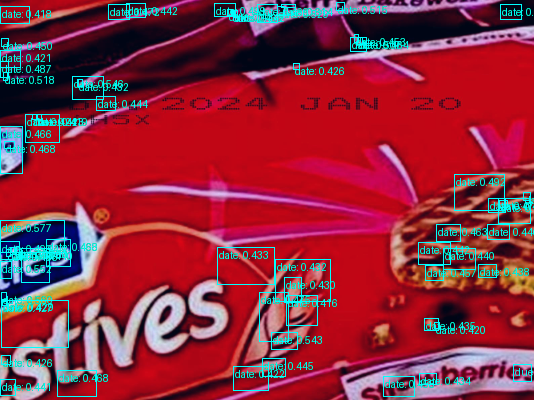

In [4]:
import sys
# Since the notebooks are in one folder apart, we have to go one step above
sys.path.append('../')

from src.exp_date_recognition.detection.detect import detect
from src.exp_date_recognition.detection.model.resnet50 import get_model_instance

random_idx = random.randint(0, hf_dataset["train"].num_rows)
example = hf_dataset["train"][random_idx]
image = Image.open(example["image_path"]).convert("RGB")

# load the model
model = get_model_instance(4, False)

annotated_image, bboxes, labels = detect(model, image, categories=categories)

# Drawing bounding boxes on the image
to_pil_image(
    draw_bounding_boxes(
        annotated_image,
        bboxes,
        colors="cyan",
        labels=labels,
    )
)

These functions define various augmentation pipelines using the Albumentations library, commonly used in computer vision tasks for preprocessing and augmenting images. Each function serves a specific purpose, such as generating augmentations for training data, test/validation data, or visualization. Additionally, there are functions for obtaining basic augmentations and for setting up transformations for handling bounding boxes along with image augmentation. You can go and check the code to see the different data augmentations used

In [5]:
from src.exp_date_recognition.detection.transformations import get_train_transform, get_test_transform, get_viz_transform

This code defines two functions for processing and visualizing images with bounding boxes.

* process_image() takes an image path, bounding box coordinates, and category labels as input, converts the image to RGB format, applies the defined visualization transformations, and returns the transformed image and bounding box coordinates.

* visualize_image() takes the transformed image, bounding box coordinates, and category labels, converts the image to tensor format, stacks the bounding box coordinates, draws bounding boxes with labels on the image, and returns the final visualized image.

Finally, the code demonstrates the usage of these functions by processing an example image and its associated bounding box information, then visualizing the augmented image with labeled bounding boxes.

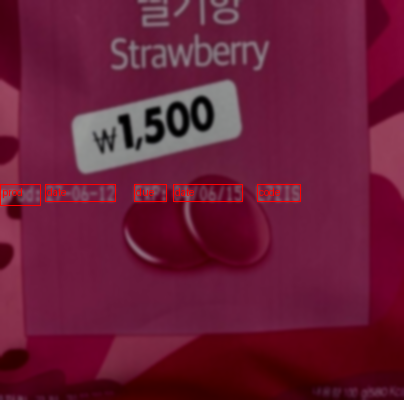

In [6]:
import numpy as np

def process_image(image_path, bboxes_block, categories):
    image = np.array(Image.open(image_path).convert("RGB"))
    out = get_viz_transform()(
        image=image,
        bboxes=bboxes_block,
        categories=categories,
    )
    return out['image'], out['bboxes']

def visualize_image(image, bboxes, labels):
    image = torch.tensor(image).permute(2, 0, 1)
    boxes_xyxy = torch.stack([torch.tensor(x) for x in bboxes])
    return to_pil_image(
        draw_bounding_boxes(
            image,
            boxes_xyxy,
            colors='red',
            labels=labels
        )
    )

random_idx = random.randint(0, hf_dataset["train"].num_rows)
example = hf_dataset["train"][random_idx]
image_path = example["image_path"]
bboxes_block = example['bboxes_block']
labels = [categories.int2str(x) for x in example['categories']]

# Augmented image
image, bboxes = process_image(image_path, bboxes_block, example['categories'])
visualize_image(image, bboxes, labels)

Create the datasets of training and validation, using a Pytorch dataset to use our defined transformations based on the hugging face dataset,
We are going to take 500 images for running it faster, but the dataset contains 11858 and can be used complete for better results

In [17]:
from src.exp_date_recognition.detection.dataset import ExpirationDateDataset 

# use our dataset and defined transformations
dataset = ExpirationDateDataset(hf_dataset["train"].select(range(500)), get_train_transform())
dataset_test = ExpirationDateDataset(hf_dataset["test"].select(range(100)) , get_test_transform())

Create a basic collate function, this function will just put together the images within the batch

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

Load the model and create the optimizer, the dataloader and the learning rate scheduler

In [19]:
# our dataset four classes - prod, date, due, code
num_classes = 4

# get the model using our helper function
model = get_model_instance(num_classes, load_fine_tunned=False)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0001
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

Define a save model callback

In [23]:
PATH = "exp_date_detector.pt"

def save_model(model, optimizer, epoch):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

Fine tune the model!, you can increase the number of epochs

In [21]:
from src.exp_date_recognition.detection.train import train

train(
    model,
    data_loader_train=data_loader,
    data_loader_test=data_loader_test,
    optimizer=optimizer,
    num_epochs=4,
    lr_scheduler=lr_scheduler,
    save_model_callback=save_model
)

Epoch: [0]  [  0/500]  eta: 0:02:39  lr: 0.001000  loss: 2.4893 (2.4893)  loss_classifier: 1.3008 (1.3008)  loss_box_reg: 0.0073 (0.0073)  loss_objectness: 1.0573 (1.0573)  loss_rpn_box_reg: 0.1239 (0.1239)  time: 0.3188  data: 0.0932  max mem: 1569
Epoch: [0]  [ 10/500]  eta: 0:02:07  lr: 0.001000  loss: 0.7834 (1.1195)  loss_classifier: 0.0983 (0.2853)  loss_box_reg: 0.0132 (0.0503)  loss_objectness: 0.4760 (0.6673)  loss_rpn_box_reg: 0.0662 (0.1167)  time: 0.2611  data: 0.0101  max mem: 1774
Epoch: [0]  [ 20/500]  eta: 0:02:03  lr: 0.001000  loss: 0.5432 (0.7903)  loss_classifier: 0.1030 (0.2046)  loss_box_reg: 0.0405 (0.0536)  loss_objectness: 0.2534 (0.4340)  loss_rpn_box_reg: 0.0606 (0.0980)  time: 0.2536  data: 0.0019  max mem: 1831
Epoch: [0]  [ 30/500]  eta: 0:02:00  lr: 0.001000  loss: 0.2988 (0.6408)  loss_classifier: 0.1030 (0.1753)  loss_box_reg: 0.0426 (0.0519)  loss_objectness: 0.1069 (0.3313)  loss_rpn_box_reg: 0.0533 (0.0823)  time: 0.2546  data: 0.0019  max mem: 1889


Let's check the model again after the 4 epochs

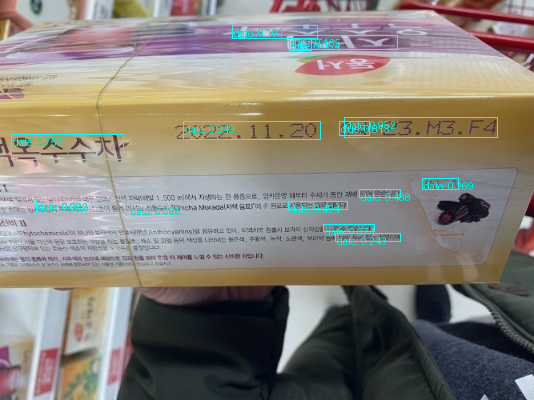

In [22]:
random_idx = random.randint(0, hf_dataset["test"].num_rows)
example = hf_dataset["test"][random_idx]
image = Image.open(example["image_path"]).convert("RGB")

annotated_image, bboxes, labels = detect(model, image, categories=categories)

# Drawing bounding boxes on the image
to_pil_image(
    draw_bounding_boxes(
        annotated_image,
        bboxes,
        colors="cyan",
        labels=labels,
    )
)

It is still not good enough but with more images in the dataset and more epochs, you could achieve results similar to those in [detect notebook](https://github.com/dimun/exp-date-recognition/blob/master/notebooks/detect.ipynb)